# Лабораторная работа 8

In [28]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from typing import Tuple, List
import time

In [29]:
def analytical_solution(a: float, x: float, y: float, t: float) -> float:
    """Аналитическое решение U(x, y, t) = cos(2x) * cosh(y) * exp(-3at)"""
    return math.cos(2*x) * math.cosh(y) * math.exp(-3*a*t)

# Граничные условия
def u_0yt(a: float, y: float, t: float) -> float:
    """u(0, y, t) = cosh(y) * exp(-3at)"""
    return math.cosh(y) * math.exp(-3*a*t)

def u_pi4yt(a: float, y: float, t: float) -> float:
    """u(π/4, y, t) = 0"""
    return 0.0

def u_x0t(a: float, x: float, t: float) -> float:
    """u(x, 0, t) = cos(2x) * exp(-3at)"""
    return math.cos(2*x) * math.exp(-3*a*t)

def u_xln2t(a: float, x: float, t: float) -> float:
    """u(x, ln2, t) = 5/4 * cos(2x) * exp(-3at)"""
    return 1.25 * math.cos(2*x) * math.exp(-3*a*t)

# Начальное условие
def initial_condition(x: float, y: float) -> float:
    """u(x, y, 0) = cos(2x) * cosh(y)"""
    return math.cos(2*x) * math.cosh(y)

def max_abs_error(A: np.ndarray, B: np.ndarray) -> float:
    """Максимальная абсолютная погрешность"""
    return np.abs(A - B).max()

def mean_abs_error(A: np.ndarray, B: np.ndarray) -> float:
    """Средняя абсолютная погрешность"""
    return np.abs(A - B).mean()

In [30]:
def tridiagonal_solve(a: np.ndarray, b: np.ndarray, c: np.ndarray, d: np.ndarray) -> np.ndarray:
    """
    Решение трехдиагональной системы методом прогонки
    """
    n = len(d)
    if n == 0:
        return np.array([])

    # Прямой ход
    alpha = np.zeros(n)
    beta = np.zeros(n)

    alpha[0] = -c[0] / b[0]
    beta[0] = d[0] / b[0]

    for i in range(1, n-1):
        denominator = b[i] + a[i] * alpha[i-1]
        alpha[i] = -c[i] / denominator
        beta[i] = (d[i] - a[i] * beta[i-1]) / denominator

    # Обратный ход
    x = np.zeros(n)
    x[n-1] = (d[n-1] - a[n-1] * beta[n-2]) / (b[n-1] + a[n-1] * alpha[n-2])

    for i in range(n-2, -1, -1):
        x[i] = alpha[i] * x[i+1] + beta[i]

    return x

In [31]:
def method_of_variable_directions(a: float, x: np.ndarray, y: np.ndarray,
                                 hx: float, hy: float, tau: float,
                                 time_steps: int) -> np.ndarray:
    """
    Метод переменных направлений (ADI) для двумерного уравнения теплопроводности
    """
    nx = len(x)
    ny = len(y)

    # Инициализация решения (K+1 временных слоев)
    U = np.zeros((time_steps + 1, nx, ny))

    # Начальное условие
    for i in range(nx):
        for j in range(ny):
            U[0, i, j] = initial_condition(x[i], y[j])

    # Коэффициенты
    sigma_x = a * tau / (2 * hx**2)
    sigma_y = a * tau / (2 * hy**2)

    # Основной цикл по времени
    for k in range(time_steps):
        t = k * tau
        t_half = t + tau/2

        # Промежуточный шаг (неявно по y, явно по x)
        U_half = np.zeros((nx, ny))

        # 1-й полушаг: (I - sigma_y * Δ_y) U^{k+1/2} = (I + sigma_x * Δ_x) U^k
        for i in range(1, nx-1):
            # Коэффициенты для прогонки по y
            a_coeff = np.zeros(ny)
            b_coeff = np.zeros(ny)
            c_coeff = np.zeros(ny)
            d_coeff = np.zeros(ny)

            for j in range(1, ny-1):
                a_coeff[j] = -sigma_y
                b_coeff[j] = 1 + 2*sigma_y
                c_coeff[j] = -sigma_y

                # Правая часть: явная схема по x
                explicit_x = sigma_x * (U[k, i+1, j] - 2*U[k, i, j] + U[k, i-1, j])
                d_coeff[j] = U[k, i, j] + explicit_x

            # Граничные условия по y
            # j = 0: u(x, 0, t+tau/2)
            b_coeff[0] = 1
            c_coeff[0] = 0
            d_coeff[0] = u_x0t(a, x[i], t_half)

            # j = ny-1: u(x, ln2, t+tau/2)
            a_coeff[ny-1] = 0
            b_coeff[ny-1] = 1
            d_coeff[ny-1] = u_xln2t(a, x[i], t_half)

            # Решение системы по y
            solution = tridiagonal_solve(a_coeff, b_coeff, c_coeff, d_coeff)
            U_half[i, :] = solution

        # Граничные условия по x для промежуточного шага
        for j in range(ny):
            U_half[0, j] = u_0yt(a, y[j], t_half)
            U_half[nx-1, j] = u_pi4yt(a, y[j], t_half)

        # 2-й полушаг: (I - sigma_x * Δ_x) U^{k+1} = (I + sigma_y * Δ_y) U^{k+1/2}
        for j in range(1, ny-1):
            # Коэффициенты для прогонки по x
            a_coeff = np.zeros(nx)
            b_coeff = np.zeros(nx)
            c_coeff = np.zeros(nx)
            d_coeff = np.zeros(nx)

            for i in range(1, nx-1):
                a_coeff[i] = -sigma_x
                b_coeff[i] = 1 + 2*sigma_x
                c_coeff[i] = -sigma_x

                # Правая часть: явная схема по y
                explicit_y = sigma_y * (U_half[i, j+1] - 2*U_half[i, j] + U_half[i, j-1])
                d_coeff[i] = U_half[i, j] + explicit_y

            # Граничные условия по x
            # i = 0: u(0, y, t+tau)
            b_coeff[0] = 1
            c_coeff[0] = 0
            d_coeff[0] = u_0yt(a, y[j], t + tau)

            # i = nx-1: u(π/4, y, t+tau)
            a_coeff[nx-1] = 0
            b_coeff[nx-1] = 1
            d_coeff[nx-1] = u_pi4yt(a, y[j], t + tau)

            # Решение системы по x
            solution = tridiagonal_solve(a_coeff, b_coeff, c_coeff, d_coeff)
            U[k+1, :, j] = solution

        # Граничные условия по y для конечного шага
        for i in range(nx):
            U[k+1, i, 0] = u_x0t(a, x[i], t + tau)
            U[k+1, i, ny-1] = u_xln2t(a, x[i], t + tau)

    return U

In [32]:
def fractional_step_method(a: float, x: np.ndarray, y: np.ndarray,
                          hx: float, hy: float, tau: float,
                          time_steps: int) -> np.ndarray:
    """
    Правильный метод дробных шагов для двумерного уравнения теплопроводности
    """
    nx = len(x)
    ny = len(y)

    # Инициализация решения
    U = np.zeros((time_steps + 1, nx, ny))

    # Начальное условие
    for i in range(nx):
        for j in range(ny):
            U[0, i, j] = initial_condition(x[i], y[j])

    # Коэффициенты
    sigma_x = a * tau / (hx**2)
    sigma_y = a * tau / (hy**2)

    # Основной цикл по времени
    for k in range(time_steps):
        t = k * tau

        # 1-й шаг: решение по x (неявно) - промежуточное решение U^*
        U_star = U[k].copy()

        # Решаем одномерные уравнения по x для каждого фиксированного y
        for j in range(ny):
            # Коэффициенты для прогонки по x
            a_coeff = np.zeros(nx)
            b_coeff = np.zeros(nx)
            c_coeff = np.zeros(nx)
            d_coeff = np.zeros(nx)

            # Внутренние точки по x
            for i in range(1, nx-1):
                a_coeff[i] = -sigma_x
                b_coeff[i] = 1 + 2*sigma_x
                c_coeff[i] = -sigma_x
                d_coeff[i] = U[k, i, j]  # только значение на предыдущем слое

            # Граничные условия по x
            # i = 0: левая граница
            b_coeff[0] = 1
            c_coeff[0] = 0
            d_coeff[0] = u_0yt(a, y[j], t + tau)  # на ПОЛНОМ шаге по времени!

            # i = nx-1: правая граница
            a_coeff[nx-1] = 0
            b_coeff[nx-1] = 1
            d_coeff[nx-1] = u_pi4yt(a, y[j], t + tau)

            # Решаем систему
            solution = tridiagonal_solve(a_coeff, b_coeff, c_coeff, d_coeff)
            U_star[:, j] = solution

        # 2-й шаг: решение по y (неявно) - окончательное решение U^{k+1}
        for i in range(nx):
            # Коэффициенты для прогонки по y
            a_coeff = np.zeros(ny)
            b_coeff = np.zeros(ny)
            c_coeff = np.zeros(ny)
            d_coeff = np.zeros(ny)

            # Внутренние точки по y
            for j in range(1, ny-1):
                a_coeff[j] = -sigma_y
                b_coeff[j] = 1 + 2*sigma_y
                c_coeff[j] = -sigma_y
                d_coeff[j] = U_star[i, j]  # используем промежуточное решение!

            # Граничные условия по y
            # j = 0: нижняя граница
            b_coeff[0] = 1
            c_coeff[0] = 0
            d_coeff[0] = u_x0t(a, x[i], t + tau)

            # j = ny-1: верхняя граница
            a_coeff[ny-1] = 0
            b_coeff[ny-1] = 1
            d_coeff[ny-1] = u_xln2t(a, x[i], t + tau)

            # Решаем систему
            solution = tridiagonal_solve(a_coeff, b_coeff, c_coeff, d_coeff)
            U[k+1, i, :] = solution

    return U

In [33]:
def plot_solutions(solutions: dict, cur_time: float, cur_y: float,
                   x_range: Tuple[float, float], y_range: Tuple[float, float],
                   t_range: Tuple[float, float], hx: float, hy: float, tau: float):
    """
    График решений при фиксированном времени и y
    """
    x_begin, x_end = x_range
    y_begin, y_end = y_range
    t_begin, t_end = t_range

    x = np.linspace(x_begin, x_end, int((x_end - x_begin)/hx) + 1)
    y = np.linspace(y_begin, y_end, int((y_end - y_begin)/hy) + 1)
    t = np.linspace(t_begin, t_end, int((t_end - t_begin)/tau) + 1)

    # Находим индексы
    cur_t_id = np.abs(t - cur_time).argmin()
    cur_y_id = np.abs(y - cur_y).argmin()

    actual_time = t[cur_t_id]
    actual_y = y[cur_y_id]

    plt.figure(figsize=(15, 9))

    for method_name, solution in solutions.items():
        plt.plot(x, solution[cur_t_id, :, cur_y_id],
                linewidth=2, label=method_name)

    plt.xlabel('x', fontsize=12)
    plt.ylabel('u(x, y, t)', fontsize=12)
    plt.title(f'Сравнение решений при t = {actual_time:.3f}, y = {actual_y:.3f}', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_3d_solutions(solutions: dict, cur_time: float,
                      x_range: Tuple[float, float], y_range: Tuple[float, float],
                      hx: float, hy: float, tau: float):
    """
    3D визуализация всех решений на одном графике
    """
    x_begin, x_end = x_range
    y_begin, y_end = y_range

    x = np.linspace(x_begin, x_end, int((x_end - x_begin)/hx) + 1)
    y = np.linspace(y_begin, y_end, int((y_end - y_begin)/hy) + 1)
    X, Y = np.meshgrid(x, y)

    # Находим индекс времени
    t_begin, t_end = 0, 1  # предполагаем
    t = np.linspace(t_begin, t_end, int((t_end - t_begin)/tau) + 1)
    cur_t_id = np.abs(t - cur_time).argmin()
    actual_time = t[cur_t_id]

    # Создаем подграфики
    fig = plt.figure(figsize=(18, 6))

    method_names = list(solutions.keys())
    for idx, method_name in enumerate(method_names):
        ax = fig.add_subplot(1, len(method_names), idx+1, projection='3d')

        solution = solutions[method_name]
        Z = solution[cur_t_id, :, :].T  # Транспонируем для правильной ориентации

        surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis,
                              alpha=0.8, linewidth=0, antialiased=True)

        ax.set_xlabel('x', fontsize=10)
        ax.set_ylabel('y', fontsize=10)
        ax.set_zlabel('u(x,y,t)', fontsize=10)
        ax.set_title(f'{method_name}\nt = {actual_time:.3f}', fontsize=12)

        fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10)

    plt.suptitle(f'3D визуализация решений в момент времени t = {actual_time:.3f}',
                fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

def plot_error_analysis(analytical: np.ndarray, numerical_methods: dict,
                       x: np.ndarray, y: np.ndarray, t: np.ndarray,
                       method_names: List[str]):
    """
    Анализ ошибок на одном графике
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Выбираем середины для срезов
    t_mid = len(t) // 2
    x_mid = len(x) // 2
    y_mid = len(y) // 2

    # График 1: Ошибка по времени (в фиксированной точке)
    ax1 = axes[0]
    for method_name, solution in numerical_methods.items():
        error_t = np.zeros(len(t))
        for k in range(len(t)):
            error_t[k] = abs(analytical[k, x_mid, y_mid] - solution[k, x_mid, y_mid])
        ax1.plot(t, error_t, linewidth=2, label=method_name)

    ax1.set_xlabel('Время t', fontsize=12)
    ax1.set_ylabel('Абсолютная ошибка', fontsize=12)
    ax1.set_title(f'Ошибка в точке (x={x[x_mid]:.3f}, y={y[y_mid]:.3f})', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # График 2: Ошибка по x (при фиксированных y и t)
    ax2 = axes[1]
    for method_name, solution in numerical_methods.items():
        error_x = np.zeros(len(x))
        for i in range(len(x)):
            error_x[i] = abs(analytical[t_mid, i, y_mid] - solution[t_mid, i, y_mid])
        ax2.plot(x, error_x, linewidth=2, label=method_name)

    ax2.set_xlabel('x', fontsize=12)
    ax2.set_ylabel('Абсолютная ошибка', fontsize=12)
    ax2.set_title(f'Ошибка при t={t[t_mid]:.3f}, y={y[y_mid]:.3f}', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # График 3: Ошибка по y (при фиксированных x и t)
    ax3 = axes[2]
    for method_name, solution in numerical_methods.items():
        error_y = np.zeros(len(y))
        for j in range(len(y)):
            error_y[j] = abs(analytical[t_mid, x_mid, j] - solution[t_mid, x_mid, j])
        ax3.plot(y, error_y, linewidth=2, label=method_name)

    ax3.set_xlabel('y', fontsize=12)
    ax3.set_ylabel('Абсолютная ошибка', fontsize=12)
    ax3.set_title(f'Ошибка при t={t[t_mid]:.3f}, x={x[x_mid]:.3f}', fontsize=14)
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    plt.suptitle('Анализ ошибок численных методов', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


In [34]:
def main():
    print("="*70)
    print("РЕШЕНИЕ ДВУМЕРНОГО УРАВНЕНИЯ ТЕПЛОПРОВОДНОСТИ")
    print("="*70)

    # Параметры
    a = 1.0
    Nx = 30
    Ny = 30
    K = 100
    total_time = 1.0

    # Шаги сетки
    hx = (math.pi / 4) / (Nx - 1)
    hy = math.log(2) / (Ny - 1)
    tau = total_time / K

    # Создание сеток
    x = np.linspace(0, math.pi/4, Nx)
    y = np.linspace(0, math.log(2), Ny)
    t = np.linspace(0, total_time, K + 1)

    print(f"Параметры задачи:")
    print(f"  a = {a}")
    print(f"  Область: x ∈ [0, π/4] ≈ [0, {math.pi/4:.3f}], y ∈ [0, ln2] ≈ [0, {math.log(2):.3f}]")
    print(f"  Сетка: {Nx} × {Ny} узлов, {K} временных шагов")
    print(f"  Шаги: hx = {hx:.4f}, hy = {hy:.4f}, τ = {tau:.6f}")
    print(f"  Общее время: t ∈ [0, {total_time}]")
    print()

    import time as timer

    # 1. Аналитическое решение
    print("1. Вычисление аналитического решения...")
    start_time = timer.time()
    analytical = np.zeros((K+1, Nx, Ny))
    for k in range(K+1):
        for i in range(Nx):
            for j in range(Ny):
                analytical[k, i, j] = analytical_solution(a, x[i], y[j], t[k])
    print(f"   Время: {timer.time() - start_time:.2f} секунд")

    # 2. Метод переменных направлений
    print("\n2. Решение методом переменных направлений...")
    start_time = timer.time()
    solution_adi = method_of_variable_directions(a, x, y, hx, hy, tau, K)
    adi_time = timer.time() - start_time
    print(f"   Время: {adi_time:.2f} секунд")

    # 3. Метод дробных шагов
    print("\n3. Решение методом дробных шагов...")
    start_time = timer.time()
    solution_fs = fractional_step_method(a, x, y, hx, hy, tau, K)
    fs_time = timer.time() - start_time
    print(f"   Время: {fs_time:.2f} секунд")

    # Вычисление ошибок
    error_adi = max_abs_error(analytical, solution_adi)
    error_fs = max_abs_error(analytical, solution_fs)

    mean_error_adi = mean_abs_error(analytical, solution_adi)
    mean_error_fs = mean_abs_error(analytical, solution_fs)

    print("\n" + "="*70)
    print("РЕЗУЛЬТАТЫ")
    print("="*70)
    print("Максимальная абсолютная погрешность:")
    print(f"  Метод переменных направлений: {error_adi:.6e}")
    print(f"  Метод дробных шагов:         {error_fs:.6e}")

    print("\nСредняя абсолютная погрешность:")
    print(f"  Метод переменных направлений: {mean_error_adi:.6e}")
    print(f"  Метод дробных шагов:         {mean_error_fs:.6e}")

    print("\nВремя вычислений:")
    print(f"  Метод переменных направлений: {adi_time:.2f} сек")
    print(f"  Метод дробных шагов:         {fs_time:.2f} сек")

    # Словарь решений для графиков
    solutions = {
        'Аналитическое решение': analytical,
        'Метод переменных направлений': solution_adi,
        'Метод дробных шагов': solution_fs
    }

    # Словарь численных методов для анализа ошибок
    numerical_methods = {
        'Метод переменных направлений': solution_adi,
        'Метод дробных шагов': solution_fs
    }

    print("\n" + "="*70)
    print("ВИЗУАЛИЗАЦИЯ")
    print("="*70)

    # 1. График решений при фиксированном времени и y
    print("\n1. График решений при фиксированном времени и y:")
    plot_solutions(solutions, cur_time=0.5, cur_y=0.5,
                   x_range=(0, math.pi/4), y_range=(0, math.log(2)),
                   t_range=(0, total_time), hx=hx, hy=hy, tau=tau)

    # 2. 3D визуализация всех решений
    print("\n2. 3D визуализация решений:")
    plot_3d_solutions(solutions, cur_time=0.5,
                      x_range=(0, math.pi/4), y_range=(0, math.log(2)),
                      hx=hx, hy=hy, tau=tau)

    # 3. Анализ ошибок на одном графике
    print("\n3. Анализ ошибок:")
    plot_error_analysis(analytical, numerical_methods, x, y, t,
                       ['Метод переменных направлений', 'Метод дробных шагов'])

РЕШЕНИЕ ДВУМЕРНОГО УРАВНЕНИЯ ТЕПЛОПРОВОДНОСТИ
Параметры задачи:
  a = 1.0
  Область: x ∈ [0, π/4] ≈ [0, 0.785], y ∈ [0, ln2] ≈ [0, 0.693]
  Сетка: 30 × 30 узлов, 100 временных шагов
  Шаги: hx = 0.0271, hy = 0.0239, τ = 0.010000
  Общее время: t ∈ [0, 1.0]

1. Вычисление аналитического решения...
   Время: 0.09 секунд

2. Решение методом переменных направлений...
   Время: 0.61 секунд

3. Решение методом дробных шагов...
   Время: 0.49 секунд

РЕЗУЛЬТАТЫ
Максимальная абсолютная погрешность:
  Метод переменных направлений: 2.794492e-04
  Метод дробных шагов:         9.761193e-03

Средняя абсолютная погрешность:
  Метод переменных направлений: 2.276854e-05
  Метод дробных шагов:         9.551967e-04

Время вычислений:
  Метод переменных направлений: 0.61 сек
  Метод дробных шагов:         0.49 сек

ВИЗУАЛИЗАЦИЯ

1. График решений при фиксированном времени и y:


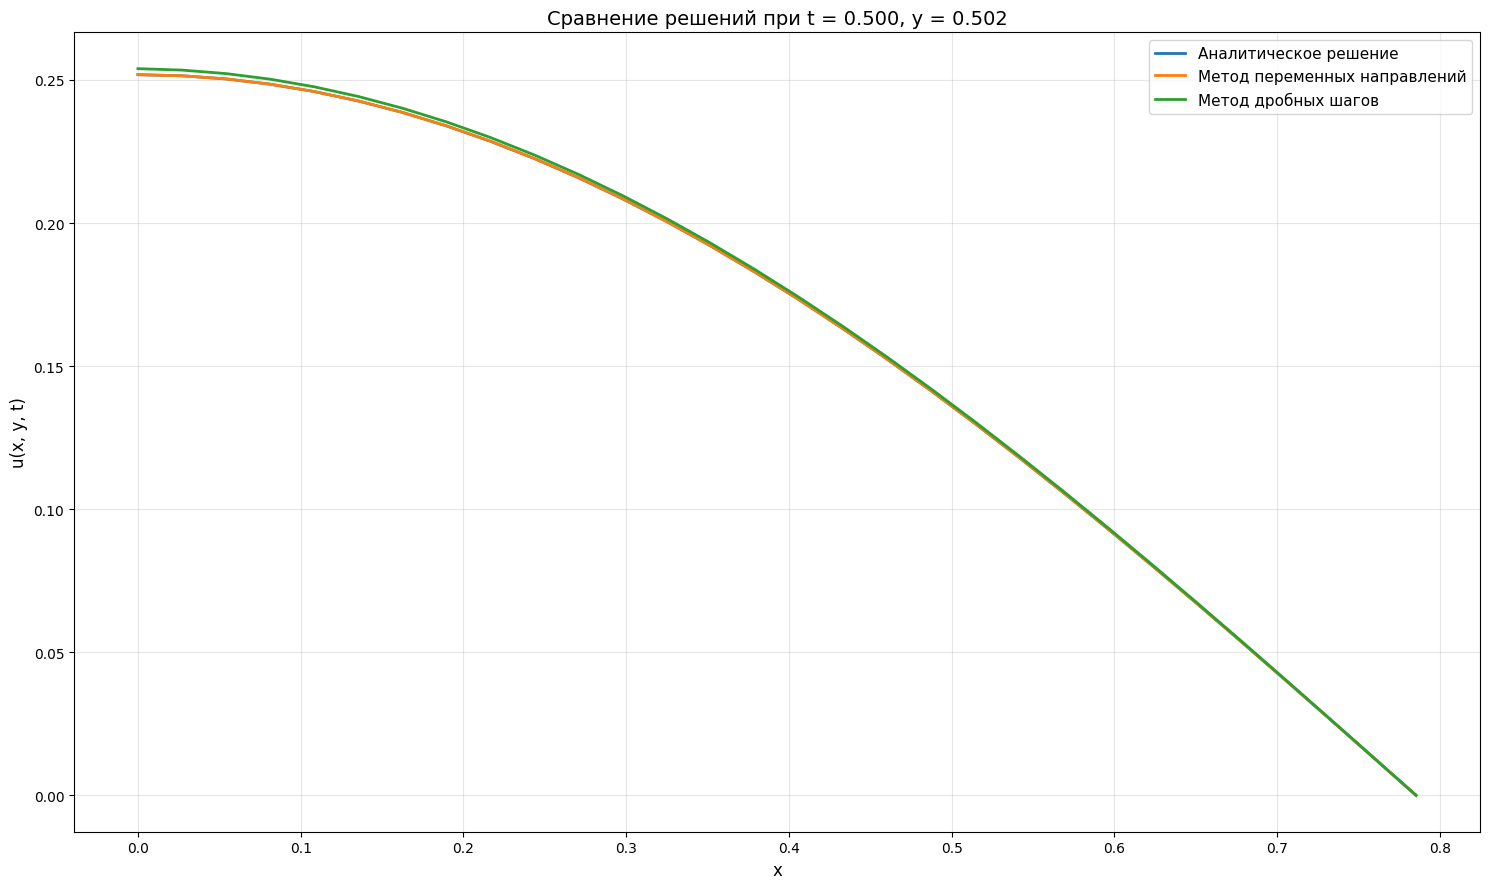


2. 3D визуализация решений:


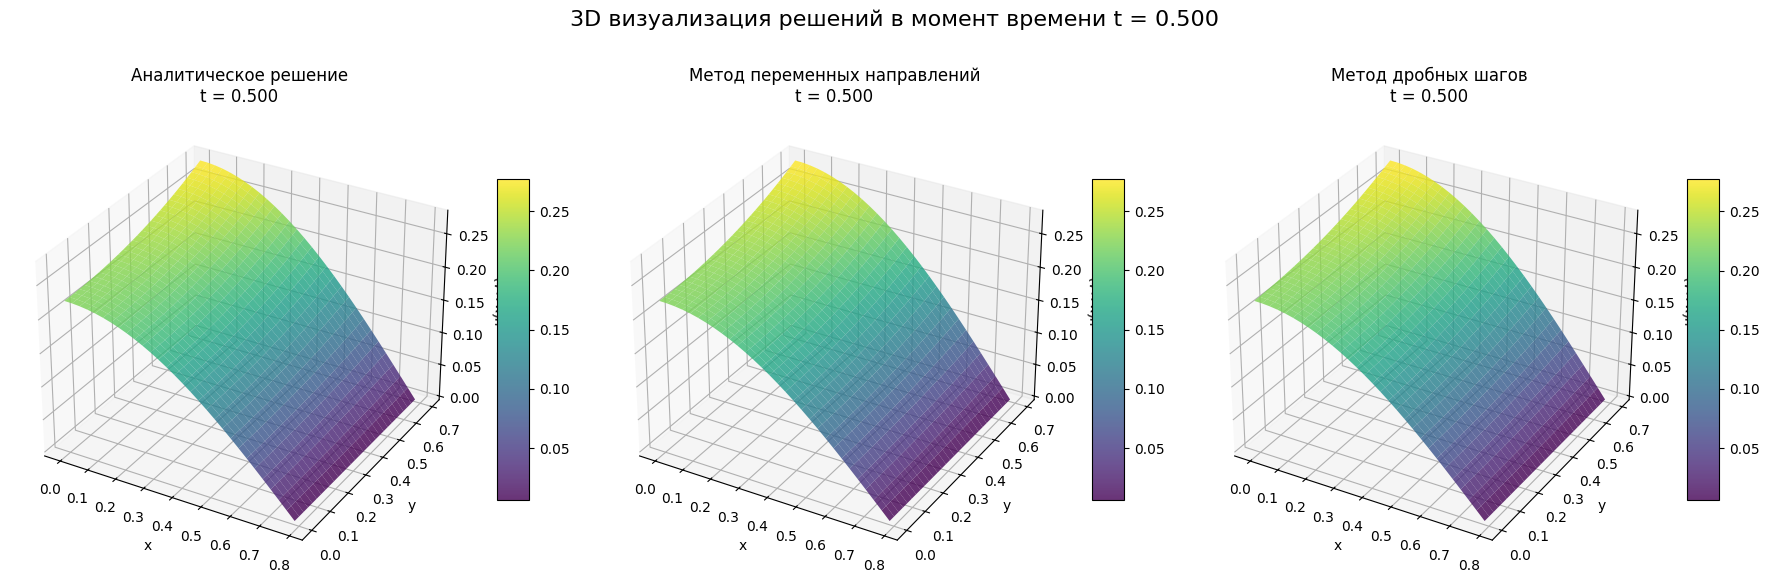


3. Анализ ошибок:


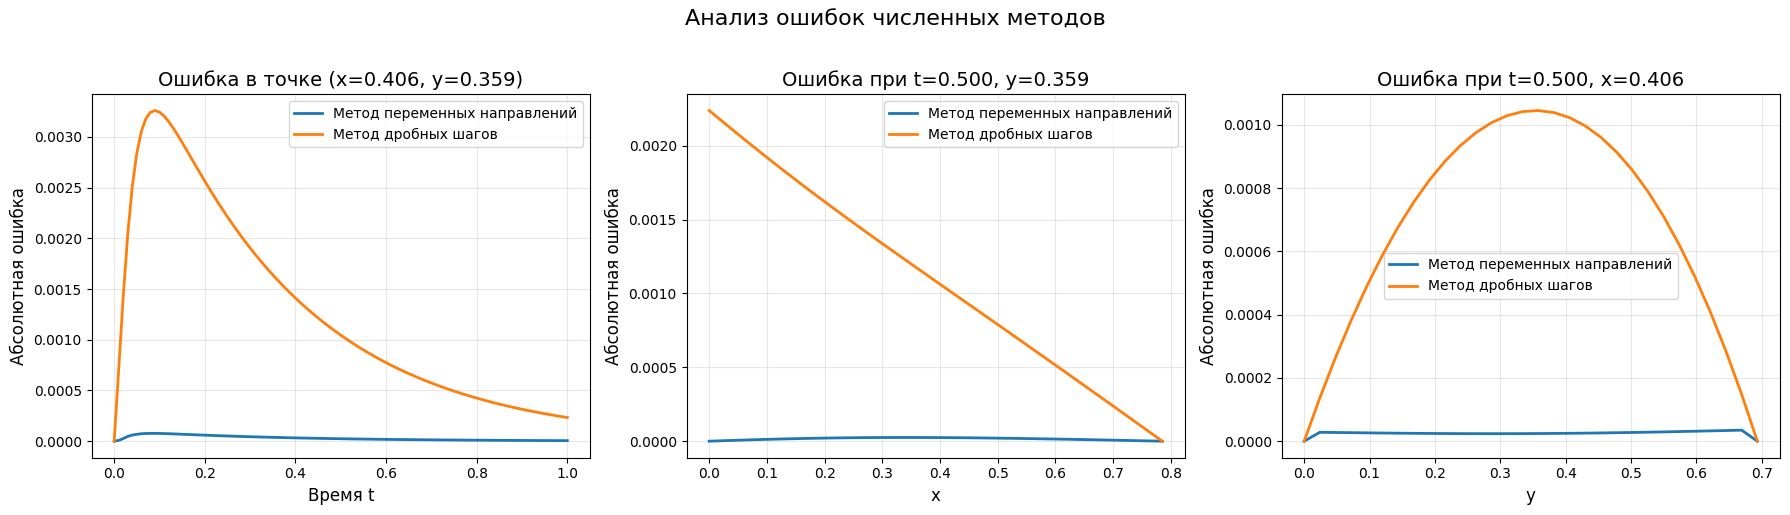

In [35]:
if __name__ == "__main__":
    main()